In [1]:
import SinglePython
import pandas as pd
import numpy as np

In [2]:
refDataset = pd.read_csv("./Data/Reference/hpca_data.csv", sep=";", decimal = ",", index_col = 0)
refDataset = refDataset.astype('float')

annot = pd.read_csv("./Data/Reference/hpca_annot.csv",sep=";", index_col = 0)
annot.columns=["cellType"]

In [8]:
#An example for a single experiment
import utils as u
data = u.readData_SingleR("./Data/Datasets/filtered_feature_bc_matrix/", 250)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
#For details of parameters
help(SinglePython.SinglePythonObject)

Help on class SinglePythonObject in module SinglePython:

class SinglePythonObject(builtins.object)
 |  SinglePythonObject(scData, refDataset, annot=None, fine_tuning=False, tuning_by='top_n', tuning_threshold=0.05, tuning_top_n=7, min_gene_th=500, de_genes_n=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, scData, refDataset, annot=None, fine_tuning=False, tuning_by='top_n', tuning_threshold=0.05, tuning_top_n=7, min_gene_th=500, de_genes_n=None)
 |      Contructor function for SinglePython class.
 |      
 |      Parameters
 |      ----------
 |      sc_location : Str
 |          the location of sc-RNAseq data.
 |          
 |      refDataset : DataFrame
 |          The reference dataset gene expression matrix.
 |          
 |      annot : DataFrame
 |          Annotations for each column in ref_data.
 |          
 |      fine_tuning : Boolean
 |          If fine tuning will be applied.
 |          
 |      tuning_by : Str
 |          There are two tuning options. It can 

In [10]:
singler = SinglePython.SinglePythonObject(data, refDataset, annot, fine_tuning=True, tuning_by="top_n")

In [11]:
result = singler.annotateCellTypes()

/projects/processedData/2018/IDV/fnabs_single_cell/data_merging/singler/SingleRToPython/tuning.py:42: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  [d.update({i:np.sort(scores.sort_index(by=i,ascending=False).index.values[0:n])}) for i in scores.columns]
/projects/processedData/2018/IDV/fnabs_single_cell/data_merging/singler/SingleRToPython/tuning.py:100: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  return [scores.sort_index(by=i,ascending=False).index.values[0:len(top_labels)-1] for i in scores.columns]


In [12]:
result.final_annotations

,AAACCCAAGGAGAGTA-1,AAACGCTTCAGCCCAG-1,AAAGAACAGACGACTG-1,AAAGAACCAATGGCAG-1,AAAGAACGTCTGCAAT-1,AAAGGATAGTAGACAT-1,AAAGGATCACCGGCTA-1,AAAGGATTCAGCTTGA-1,AAAGGATTCCGTTTCG-1,AAAGGGCTCATGCCCT-1,...,TTTCACATCTCAGGCG-1,TTTCATGGTGCCTAAT-1,TTTCATGTCACTCACC-1,TTTCCTCCACAGAGCA-1,TTTCCTCTCCTACACC-1,TTTCCTCTCTCTTGCG-1,TTTGATCTCTTTGGAG-1,TTTGGTTAGTAACCTC-1,TTTGGTTGTAGAATAC-1,TTTGTTGCAATTAGGA-1
final_annotations,Monocyte:CD16-,B_cell:Naive,T_cell:CD4+_effector_memory,T_cell:CD8+,T_cell:CD4+_central_memory,B_cell:Memory,B_cell:Naive,Monocyte:CD16-,Monocyte:CD16-,T_cell:CD4+_Naive,...,B_cell:immature,B_cell:Memory,Monocyte:CD16-,B_cell:immature,T_cell:CD4+_effector_memory,Monocyte:CD16+,T_cell:CD4+_central_memory,T_cell:CD4+_central_memory,Monocyte:CD16-,B_cell:immature


In [13]:
def performSamplePreparation(data, minCounts, maxCounts, minGenes, minCells, maxPercentMito = .1):
    matplotlib.rcParams['figure.figsize'] = [3, 3]
    
    data.var_names_make_unique()
    
    print(data)
    

    
    data.raw = data.copy()
    
    mito_genes = [name for name in data.var_names if name.startswith("MT-")]
    data.obs['percent_mito'] = np.ravel(np.sum(
    data[:, mito_genes].X, axis=1)) / np.ravel(np.sum(data.X, axis=1))
    data.obs['n_counts'] = np.ravel(np.sum(data.X, axis=1))
    
    sc.pp.filter_cells(data, min_genes=0) # Hack to generate the n_genes column
    sc.pp.filter_genes(data, min_cells=0)
    
    priorFilteringCellCount = data.n_obs
    priorFilteringGeneCount = len(data.var[data.var["n_cells"] > 0])
    
    
    sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
    
    sc.pp.filter_cells(data, min_genes=minGenes)
    sc.pp.filter_genes(data, min_cells=minCells) 
    
    sc.pl.scatter(data, x='n_counts', y='percent_mito')
    sc.pl.scatter(data, x='n_counts', y='n_genes')
    
    data = data[data.obs['n_counts'] > minCounts, :]
    data = data[data.obs['n_counts'] < maxCounts, :]
    data = data[data.obs['percent_mito'] < maxPercentMito, :]
    
 #   data_raw = sc.pp.log1p(data, copy=True)
    
    
    postFilteringCellCount = data.n_obs
    postFilteringGeneCount = len(data.var[data.var["n_cells"] > 0])
    
    sc.pp.normalize_per_cell(data, counts_per_cell_after=1e4)
    filter_result = sc.pp.filter_genes_dispersion(
        data.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.filter_genes_dispersion(filter_result)

    data = data[:, filter_result.gene_subset]
    
    
    hgvFilteringGeneCount = len(filter_result.gene_subset)
    hgvFilteringCellCount = len(data.var[data.var["n_cells"] > 0])
    
    sc.pp.log1p(data)
        
    sc.tl.pca(data)
    sc.pl.pca(data)
    
    
    sc.pp.filter_genes(data, min_counts=1) # Remove unwanted zero count genes
    
    sc.pp.regress_out(data, ['n_counts'])
    
    sc.pp.scale(data, max_value=10)
    
    sc.tl.pca(data)
    sc.pl.pca(data)
    
    sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito'],
        jitter=0.4, multi_panel=True, use_raw = False)
    
    
    
    print(data)
    return data

In [14]:
import os
import matplotlib
import scanpy.api as sc
import scipy.io
import numpy as np

def readData(path):    
    matplotlib.rcParams['figure.figsize'] = [3, 3]
    
    data = sc.read(path + 'matrix.mtx', cache=True).transpose()
    data.var_names = np.genfromtxt(path + 'genes.tsv', dtype=str)[:, 1]
    data.obs_names = np.genfromtxt(path + 'barcodes.tsv', dtype=str)
    
    return performSamplePreparation(data, 500, 25000, 0, 3)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1222 × 33538 


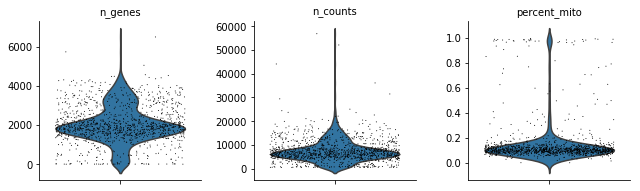

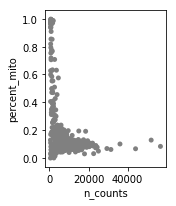

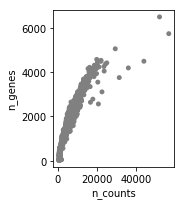

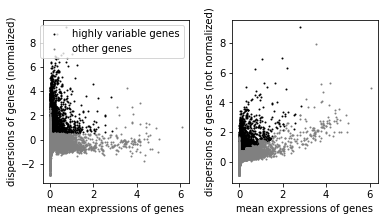

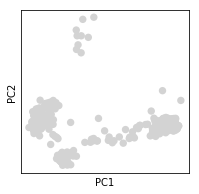

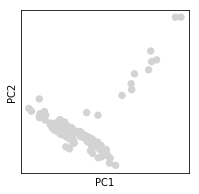

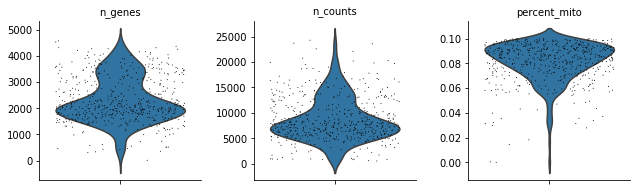

AnnData object with n_obs × n_vars = 549 × 2567 
    obs: 'percent_mito', 'n_counts', 'n_genes'
    var: 'n_cells', 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [16]:
sampleCleanedCountMatrix = readData("./Data/Datasets/filtered_feature_bc_matrix/")

In [18]:
def cluster(data):
    sc.pp.scale(data, max_value=10)
    sc.tl.pca(data)
    sc.pp.neighbors(data)
    sc.logging.print_memory_usage()
    sc.tl.umap(data)
    sc.logging.print_memory_usage()
    sc.tl.tsne(data)
    sc.logging.print_memory_usage()

In [19]:
cluster(sampleCleanedCountMatrix)

Memory usage: current 1.20 GB, difference +1.20 GB
Memory usage: current 1.20 GB, difference +0.00 GB
Memory usage: current 1.21 GB, difference +0.00 GB


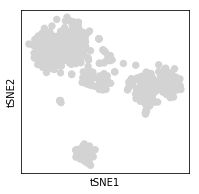

In [20]:
sc.pl.tsne(sampleCleanedCountMatrix)

In [21]:
def mergeAnnotations(scData, annotationResults):
    scData.obs["cellType"] = annotationResults.final_annotations.transpose()
    scData.obs["majorCellType"] = scData.obs["cellType"].str.split(":").str[0]
    return scData

In [23]:
merged = mergeAnnotations(sampleCleanedCountMatrix, result)

In [ ]:

sc.pl.tsne(tenx_boston_002_FNA2, color = "majorCellType")